In [ ]:
import numpy as np
file_path = r"C:\Users\pedersen\Desktop\Coding\qucs-s\schematic\harmonic_balance.dat.xyce"

In [82]:

def extract_variable_data(file_path, var_name):
    with open(file_path, "r") as file:
        lines = file.readlines()

    data = {}
    current_key = None
    collecting_data = False

    for line in lines:
        line = line.strip()

        if line.startswith("<indep") or line.startswith("<dep"):
            parts = line.split()
            current_key = parts[1]  # Extract variable name
            data[current_key] = []
            collecting_data = True
            continue

        if line.startswith("</"):
            collecting_data = False
            continue

        if collecting_data and current_key:
            if "+j" in line or "-j" in line:  # Handle complex numbers
                real, imag = line.split("+j") if "+j" in line else line.split("-j")
                imag = "-" + imag if "-j" in line else imag
                data[current_key].append(complex(float(real), float(imag)))
            else:
                data[current_key].append(float(line))

    if var_name in data:
        return np.array(data[var_name])
    else:
        raise ValueError(f"Variable '{var_name}' not found in the file.")


In [83]:
with open(file_path, "r") as file:
    lines = file.readlines()

indep_vars = []
dep_vars = []

for line in lines:
    line = line.strip()
    
    if line.startswith("<indep"):
        parts = line.split()
        indep_vars.append(parts[1])  # Extract variable name
    
    if line.startswith("<dep"):
        parts = line.split()
        dep_vars.append(parts[1])  # Extract variable name

# Print extracted variable names in a clean format
print("\nIndependent Variables:")
print("\n".join(f" - {var}" for var in indep_vars) if indep_vars else "None")

print("\nDependent Variables:")
print("\n".join(f" - {var}" for var in dep_vars) if dep_vars else "None")



Independent Variables:
 - FREQ
 - Y

Dependent Variables:
 - Re(V(COLLECTOR_VOLTAGE))
 - Im(V(COLLECTOR_VOLTAGE))
 - Re(I(VPR1))
 - Im(I(VPR1))
 - Re(I(VPR2))
 - Im(I(VPR2))
 - Re(I(VPR3))
 - Im(I(VPR3))
 - Re(V(VCC))
 - Im(V(VCC))
 - Re(V(VIN))
 - Im(V(VIN))
 - Re(V(VOUT))
 - Im(V(VOUT))
 - V(COLLECTOR_VOLTAGE)
 - I(PR1)
 - I(PR2)
 - I(PR3)
 - V(VCC)
 - V(VIN)
 - V(VOUT)


In [84]:
var_name_1 = "V(VOUT)" # complex number of the output voltage
var_name_2 = "V(VIN)" # complex number of the input voltage
var_name_3 = "I(PR2)" # complex number of the input current
var_name_4 = "I(PR3)" # complex number of the output current
var_name_5 = "Y"  # real number of the input power sweep variable
var_name_6 = "FREQ" # frequency array

Vout_complex = extract_variable_data(file_path, var_name_1)
Vin_complex = extract_variable_data(file_path, var_name_2)
Iin_complex = extract_variable_data(file_path, var_name_3)
Iout_complex = extract_variable_data(file_path, var_name_4)
Freq = extract_variable_data(file_path, var_name_6)
Y = extract_variable_data(file_path, var_name_5)

# Determine sizes
N = len(Vout_complex)  # Total data points
B = len(Y)  # Number of sections

values_per_section = N // B  # Values per section

# Ensure N is divisible by B
if N % B != 0:
    raise ValueError(f"Cannot divide {N} elements into {B} equal sections.")

# Reshape into sections
Vin_sections = np.array(Vin_complex).reshape(B, values_per_section)
Vout_sections = np.array(Vout_complex).reshape(B, values_per_section)
Iin_sections = np.array(Iin_complex).reshape(B, values_per_section)
Iout_sections = np.array(Iout_complex).reshape(B, values_per_section)


# Finding 1db compression point

In [ ]:
# finding the index of the 50 GHz frequency
index = np.where(Freq == 50e9)
index = index[0][0]

# extracting the sixth value in each section
Vin_50_Ghz_values = Vin_sections[:, index]
Vout_50_Ghz_values = Vout_sections[:, index]
Iin_50_Ghz_values = Iin_sections[:, index]
Iout_50_Ghz_values = Iout_sections[:, index]

Pout_50_Ghz_values = np.real(Vout_50_Ghz_values * np.conj(Iout_50_Ghz_values))
Pin_50_Ghz_values = np.real(Vin_50_Ghz_values * np.conj(Iin_50_Ghz_values))


#converting Pout_50_Ghz_values to dbm
Pout_50_Ghz_values_dbm = 10 * np.log10(Pout_50_Ghz_values*1000)
Pin_50_Ghz_values_dbm = 10 * np.log10(Pin_50_Ghz_values*1000)

target_40 = -40 # target value x1
target_5 = -10   # target value x2

index_40 = np.argmin(np.abs(Pin_50_Ghz_values_dbm - target_40))

index_5 = np.argmin(np.abs(Pin_50_Ghz_values_dbm - target_5))

a = (Pout_50_Ghz_values_dbm[index_40] - Pout_50_Ghz_values_dbm[index_5]) / (Pin_50_Ghz_values_dbm[index_40] - Pin_50_Ghz_values_dbm[index_5])
b = Pout_50_Ghz_values_dbm[index_40] - a * Pin_50_Ghz_values_dbm[index_40]


Pin_linear = np.linspace(Pin_50_Ghz_values_dbm[index_40], Pin_50_Ghz_values_dbm[-1], len(Pout_50_Ghz_values_dbm))
Pout_linear = a * Pin_linear + b

difference = Pout_50_Ghz_values_dbm - Pout_linear
index_p1db = np.argmin(np.abs(difference + 1)) 

index_p1db
Pin_p1db = Pin_linear[index_p1db]
Pout_p1db = Pout_linear[index_p1db]


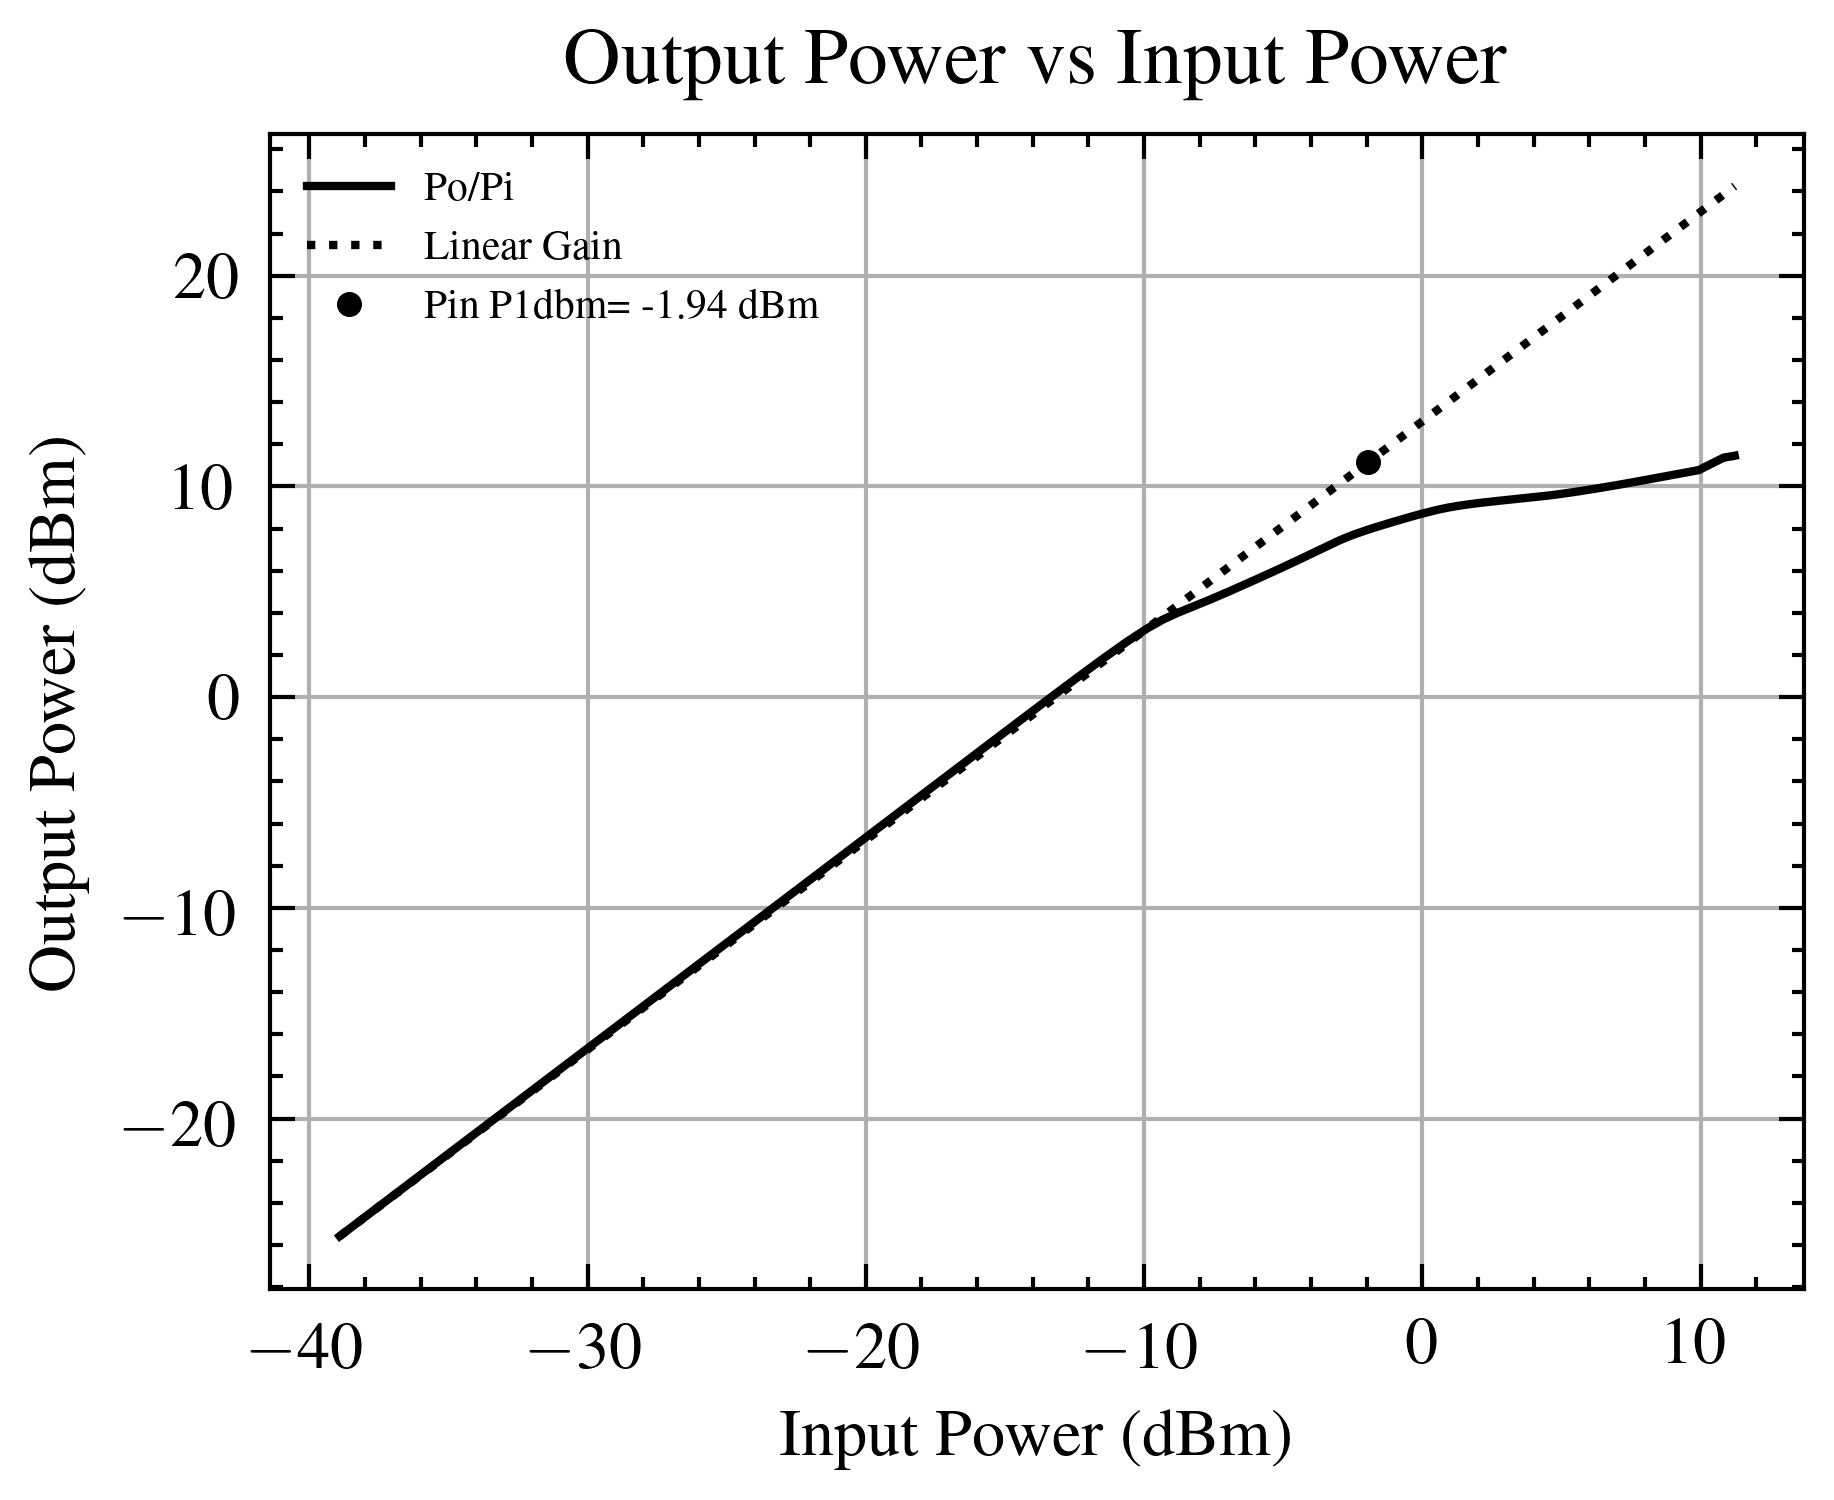

In [142]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])

# Plot the actual data
plt.plot(Pin_50_Ghz_values_dbm, Pout_50_Ghz_values_dbm, label='Po/Pi')

# Plot the linear gain curve in black and dotted
plt.plot(Pin_linear, Pout_linear, label='Linear Gain', color='black', linestyle=':')

# Plotting the 1dB compression point with smaller dot
plt.plot(Pin_p1db, Pout_p1db, 'ko', label=f'Pin P1dbm= {Pin_p1db:.2f} dBm', markersize=2)

# Labels and title
plt.xlabel("Input Power (dBm)")
plt.ylabel("Output Power (dBm)")
plt.title("Output Power vs Input Power")

# Show grid and legend with custom font size
plt.grid()
plt.legend(loc='upper left', fontsize=5)  # Adjust fontsize here

# Show the plot
plt.show()